# Chapter 2. Small Worlds and Large Worlds

In [1]:
import arviz as az
import matplotlib.pyplot as plt

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro as npyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
import numpyro.distributions as dist
from numpyro.infer import SVI
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 2.1

In [2]:
ways = np.array([0., 3, 8, 9, 0])
ways / np.sum(ways)

DeviceArray([0.        , 0.15000001, 0.40000001, 0.45000002, 0.        ],
            dtype=float32)

### Code 2.2

In [3]:
np.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(6))

DeviceArray(0.16406263, dtype=float32)

### Code 2.3

In [4]:
# define grid
p_grid = np.linspace(start=0, stop=1, num=20)

# define prior
prior = np.repeat(1, 20)

# compute likelihood at each value in grid
likelihood = np.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / np.sum(unstd_posterior)

### Code 2.4

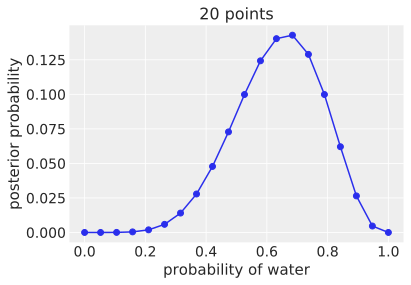

In [5]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points");

### Code 2.5

In [6]:
prior = np.where(p_grid < 0.5, 0, 1)
prior = np.exp(-5 * abs(p_grid - 0.5))

### Code 2.6

In [7]:
def model(W, L):
    p = npyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    npyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), AutoContinuousELBO(), W=6, L=3)
init_state = svi.init(PRNGKey(0))
state = lax.fori_loop(0, 1000, lambda i, x: svi.update(x)[0], init_state)
params = svi.get_params(state)

# display summary of quadratic approximation
samples = guide.sample_posterior(PRNGKey(1), params, (1000,))
npyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



### Code 2.7

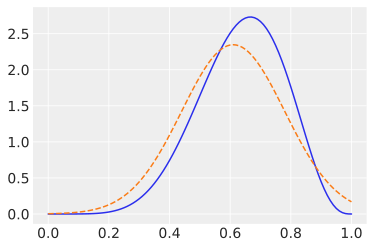

In [8]:
# analytical calculation
W = 6
L = 3
x = np.linspace(0, 1, 101)
plt.plot(x, np.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
plt.plot(x, np.exp(dist.Normal(0.61, 0.17).log_prob(x)), "--");

### Code 2.8

In [9]:
n_samples = 1000
p = [np.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with npyro.handlers.seed(rng=0):
    for i in range(1, n_samples):
        p_new = npyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = np.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = np.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = np.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = npyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]

### Code 2.9

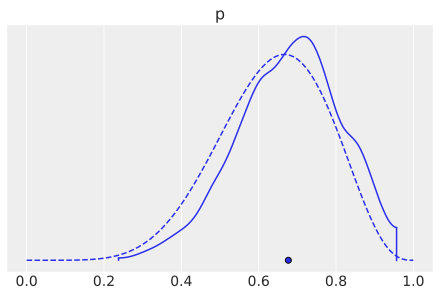

In [10]:
az.plot_density({"p": p}, credible_interval=1)
plt.plot(x, np.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "--");